In [10]:
import cv2
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import uniform_filter
from sklearn.decomposition import PCA

In [11]:
def perform_pca(data, n_components=None):
    '''
    Perform Principal Component Analysis (PCA) on the input data.

    Parameters:
    - data: Input data as a 2D NumPy array with samples in rows and features in columns.
    - n_components: Number of principal components to keep (default is None, which keeps all components).

    '''
    # Initialize the PCA model
    pca = PCA(n_components=n_components)
    # Fit the PCA model to the data and transform the data
    pca_components = pca.fit_transform(data)

    return pca_components

In [12]:
def read_video_to_array(video_path):
    '''
    Opens an MP4 video file and returns it as an array.

    Parameters:
    - video_path (str): Path to the input MP4 video file.
    '''
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frames.append(frame)
    
    cap.release()
    
    return np.array(frames)

In [13]:
def get_flow(videopath):
    '''
    Calculate optical flow between frames in a video.This function 
    takes a video file specified by 'videopath' and calculates the optical flow
    between consecutive frames using the Farneback method. 
    Optical flow represents the motion of objects in the video by estimating 
    the displacement of pixels between frames.

    Parameters:
    - videopath (str): Path to the video file.
    '''
    cap = cv2.VideoCapture(videopath)  

    # Initialize variables for the first frame
    ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

    # Create an empty list to store flow fields
    flow_fields = []

    while True:
        ret, frame2 = cap.read()
        if not ret:
            break

        # Convert the current frame to grayscale
        next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Calculate optical flow
        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 9, 1, 3, 1.1, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

        # Store the flow field
        flow_fields.append(flow)

        # Update the previous frame
        prvs = next

    cap.release()
    return flow_fields

In [14]:
def hof(flow, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), normalise=False, motion_threshold=1.):
    '''
    Extract Histogram of Optical Flow (HOF) for a given flow field.

    Parameters:
    - flow: The optical flow field as a 2D NumPy array of shape (height, width, 2).
    - orientations: Number of orientation bins.
    - pixels_per_cell: Size (in pixels) of a cell.
    - cells_per_block: Number of cells in each block.
    - normalise: Apply power law compression to normalise the flow field if True.
    - motion_threshold: Threshold for considering motion.
    '''
    # Ensure that 'flow' is at least 2D
    flow = np.atleast_2d(flow)

    # Optionally apply normalization (sqrt)
    if normalise:
        flow = np.sqrt(flow)

    # Calculate the gradient in the x and y directions
    gx = flow[:, :, 1]
    gy = flow[:, :, 0]

    # Calculate the magnitude and orientation of the gradient
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * (180 / np.pi) % 180

    # Get the shape of the flow field
    sy, sx = flow.shape[:2]
    cx, cy = pixels_per_cell
    bx, by = cells_per_block

    # Calculate the number of cells in x and y directions
    n_cellsx = int(np.floor(sx // cx))
    n_cellsy = int(np.floor(sy // cy))

    # Initialize an orientation histogram
    orientation_histogram = np.zeros((n_cellsy, n_cellsx, orientations))

    # Define a subsample for efficient calculation
    subsample = np.index_exp[cy // 2:cy * n_cellsy:cy, cx // 2:cx * n_cellsx:cx]

    # Iterate through orientation bins
    for i in range(orientations - 1):
        # Select pixels within the current orientation bin
        temp_ori = np.where(orientation < 180 / orientations * (i + 1), orientation, -1)
        temp_ori = np.where(orientation >= 180 / orientations * i, temp_ori, -1)

        # Consider only pixels with motion above the threshold
        cond2 = (temp_ori > -1) * (magnitude > motion_threshold)
        temp_mag = np.where(cond2, magnitude, 0)

        # Apply uniform filter to compute the histogram values for the cell
        temp_filt = uniform_filter(temp_mag, size=(cy, cx))
        orientation_histogram[:, :, i] = temp_filt[subsample]

    # Handle the last orientation bin
    temp_mag = np.where(magnitude <= motion_threshold, magnitude, 0)
    temp_filt = uniform_filter(temp_mag, size=(cy, cx))
    orientation_histogram[:, :, -1] = temp_filt[subsample]

    # Calculate the number of blocks in x and y directions
    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1

    # Initialize an array to store normalized blocks
    normalised_blocks = np.zeros((n_blocksy, n_blocksx, by, bx, orientations))

    # Normalize each block using L2-Hys
    for x in range(n_blocksx):
        for y in range(n_blocksy):
            block = orientation_histogram[y:y+by, x:x+bx, :]
            eps = 1e-5
            normalised_blocks[y, x, :] = block / np.sqrt(block.sum()**2 + eps)

    # Flatten the array to obtain the final HOF feature vector
    return normalised_blocks.ravel()

In [23]:
# Load the 25 frame 128x128 cubes from the gas-dataset
cubes_files = "/home/antonkout/Documents/modules/flammable_gas_detection/release/data/propane/dataset/cubes"
gas_cubes = [str(x) for x in list(Path(cubes_files).glob("*.mp4")) if '_gas.mp4' in str(x)]
gas_cubes.sort()
non_gas_cubes = [str(x) for x in list(Path(cubes_files).glob("*.mp4")) if '_nongas.mp4' in str(x)]
non_gas_cubes.sort()

In [34]:
# Select the same parameters for the calculation of HOG-HOF
a = 10 # Select which cube for the analysis
orientations = 9 # Select the number of orientation, the higher the more sensitive to motion
pixels_per_cell = (5, 5) # Select number of pixels per cell, the small the less spatial info / more sensitive to motion
cells_per_block = (3, 3) # Select the number of cells, same smaller equals to sensitivity

In [50]:
nongas = [x for x in non_gas_cubes if '_patch_13' in x]

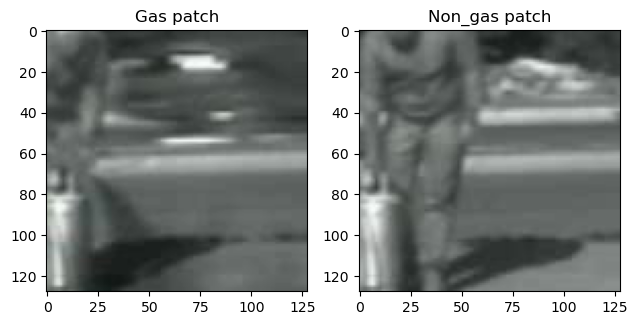

In [55]:
# Create a 1x2 subplot grid
plt.subplot(1, 2, 1)
plt.imshow(read_video_to_array(gas_cubes[a])[0])
plt.title('Gas patch')

plt.subplot(1, 2, 2)
plt.imshow(read_video_to_array(nongas[a])[0])
plt.title('Non_gas patch')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

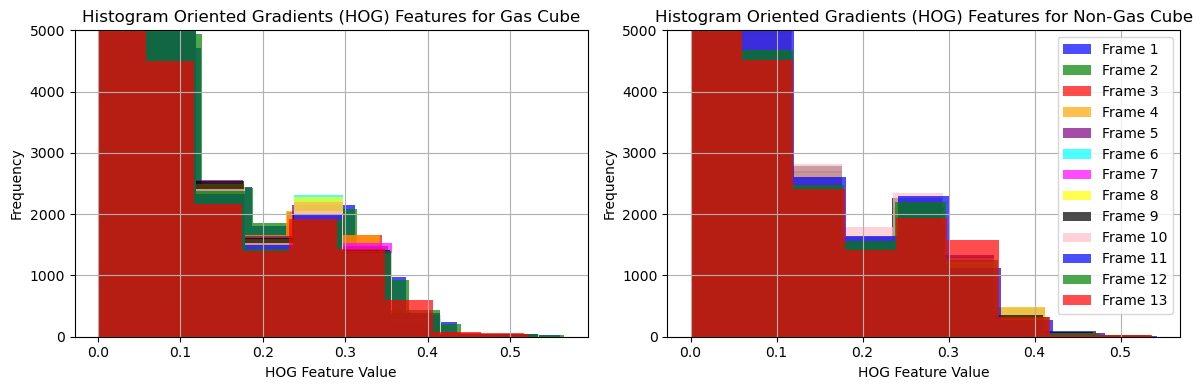

In [59]:
# Define empty lists to store results for visualization and comparison
hog_features_gas = []
hog_features_non_gas = []
gas_arr = read_video_to_array(gas_cubes[a])
non_gas_arr = read_video_to_array(nongas[a])

#Caclulation of Histogram Oriented Gradients
for frame in range(gas_arr.shape[0]):
    hog_gas_vector = hog(gas_arr[frame], orientations, pixels_per_cell, cells_per_block, block_norm='L2-Hys', visualize=False, channel_axis=-1)
    hog_features_gas.append(hog_gas_vector)
    hog_nongas_vector = hog(non_gas_arr[frame], orientations, pixels_per_cell, cells_per_block, block_norm='L2-Hys', visualize=False, channel_axis=-1)
    hog_features_non_gas.append(hog_nongas_vector)

# Convert hof_features_gas and hof_features_non_gas to NumPy arrays if needed
hog_features_gas = np.array(hog_features_gas)
hog_features_non_gas = np.array(hog_features_non_gas)

# Create a figure with two subplots (one for gas, one for non-gas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Define a list of colors for the histograms
colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'pink']

# Iterate through all entities in hof_features_gas and plot their histograms with different colors in the first subplot
for i, hog_vector in enumerate(hog_features_gas):
    ax1.hist(hog_vector, bins=orientations, alpha=0.7, color=colors[i % len(colors)], label=f'Frame {i+1}')

ax1.set_ylim(0, 5000)
ax1.set_xlabel('HOG Feature Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram Oriented Gradients (HOG) Features for Gas Cube')
ax1.grid()

# Iterate through all entities in hof_features_non_gas and plot their histograms with different colors in the second subplot
for i, hog_vector in enumerate(hog_features_non_gas):
    ax2.hist(hog_vector, bins=orientations, alpha=0.7, color=colors[i % len(colors)], label=f'Frame {i+1}')

ax2.set_ylim(0, 5000)
ax2.set_xlabel('HOG Feature Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram Oriented Gradients (HOG) Features for Non-Gas Cube')
ax2.grid()

# Adjust spacing between subplots
plt.tight_layout()
plt.legend()
# Show the combined figure
plt.show()

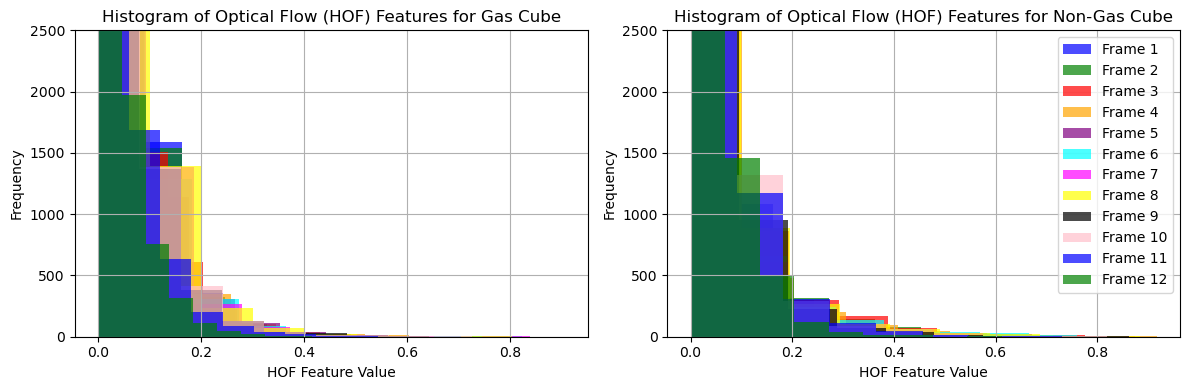

In [58]:
# Define empty lists to store results for visualization and comparison
hof_features_gas = []
hof_features_non_gas = []

flow_fields_gas = get_flow(gas_cubes[a])
flow_fields_non_gas = get_flow(nongas[a])

motion_threshold = .1 # You can adjust this threshold

# Calculate HOF features for each flow field in the gas dataset
for flow in flow_fields_gas:
    hof_vector = hof(flow, orientations, pixels_per_cell, cells_per_block, False, motion_threshold)
    hof_features_gas.append(hof_vector)

# Calculate HOF features for each flow field in the non-gas dataset
for flow in flow_fields_non_gas:
    hof_vector = hof(flow, orientations, pixels_per_cell, cells_per_block, False, motion_threshold)
    hof_features_non_gas.append(hof_vector)

# Convert hof_features_gas and hof_features_non_gas to NumPy arrays if needed
hof_features_gas = np.array(hof_features_gas)
hof_features_non_gas = np.array(hof_features_non_gas)

# Create a figure with two subplots (one for gas, one for non-gas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Define a list of colors for the histograms
colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'pink']

# Iterate through all entities in hof_features_gas and plot their histograms with different colors in the first subplot
for i, hof_vector in enumerate(hof_features_gas):
    ax1.hist(hof_vector, bins=orientations, alpha=0.7, color=colors[i % len(colors)], label=f'Entity {i+1}')

ax1.set_ylim(0, 2500)
ax1.set_xlabel('HOF Feature Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Optical Flow (HOF) Features for Gas Cube')
ax1.grid()

# Iterate through all entities in hof_features_non_gas and plot their histograms with different colors in the second subplot
for i, hof_vector in enumerate(hof_features_non_gas):
    ax2.hist(hof_vector, bins=orientations, alpha=0.7, color=colors[i % len(colors)], label=f'Frame {i+1}')

ax2.set_ylim(0, 2500)
ax2.set_xlabel('HOF Feature Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Optical Flow (HOF) Features for Non-Gas Cube')
ax2.grid()

# Adjust spacing between subplots
plt.tight_layout()
plt.legend()
# Show the combined figure
plt.show()

In [60]:
arr = np.concatenate((hog_features_gas, hof_features_gas), axis=0)
arr = hof_features_gas.copy()
arr.T.shape

(42849, 12)

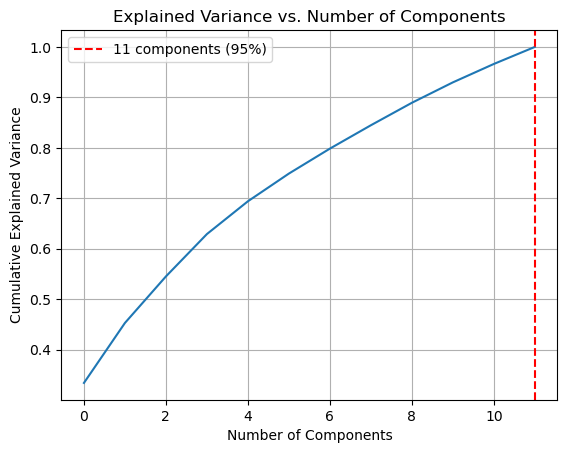

In [61]:
# Initialize PCA without specifying the number of components
pca = PCA()

# Fit PCA to the data
pca.fit(arr.T)

# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Add a red vertical line at the 95% explained variance point
plt.axvline(x=n_components_95, color='red', linestyle='--', label=f'{n_components_95} components (95%)')

# Add a legend to the plot
plt.legend()
plt.grid()
plt.show()

In [62]:
# Fit PCA to the data
pca_components = perform_pca(arr.T, n_components=n_components_95)

In [63]:
my_array = pca_components.flatten()

In [64]:
# Check the memory size in bytes
arr = arr.astype(np.float16)
# arr = np.round(arr, decimals=5)
memory_size = arr.nbytes
memory_size_mb = memory_size / (1024 * 1024)

# Print the memory size
print(f"Memory size of the array: {memory_size_mb:.2f} megabytes")

Memory size of the array: 0.98 megabytes


In [18]:
np.savez_compressed('/home/antonkout/Documents/modules/flammable_gas_detection/compressed_array.npz', my_array)